In [5]:
from src.experiment_instance import ExperimentInstance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shap
from datetime import datetime, timedelta

In [9]:
def explain(experiment, features):

    dates, inputs, true, preds = experiment.raw_results_[-1]
    experiment.dataset.data_train["data"] = np.concatenate(list(map(lambda x: x.numpy(), next(experiment.dataset.data_train["data"].batch(9999999999).__iter__())))[0])

    explainer = shap.Explainer(experiment.model, experiment.dataset.data_train["data"], feature_names=features)
    
    experiment.model.save(f'results/Demand/models/{experiment.parameters["dataset"]["name"]}.model')
    np.save(open(f'results/Demand/models/{experiment.parameters["dataset"]["name"]}_train.npy', 'wb'), experiment.dataset.data_train["data"])
    np.save(open(f'results/Demand/models/{experiment.parameters["dataset"]["name"]}_Xtest.npy', 'wb'), inputs)
    np.save(open(f'results/Demand/models/{experiment.parameters["dataset"]["name"]}_Ytest.npy', 'wb'), true)

    shap_values = explainer(experiment.dataset.data_train["data"], max_evals=500)

    preds = preds.reshape(-1, 3)
    true = true.reshape(-1, 3)

    return shap_values, inputs

def train_and_explain(dataset, params):
    seed = 123
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    experiment = ExperimentInstance(params)
    experiment.run()

    features = np.array([f'target t-{t}'for t in range (193, 0, -1)])

    shap_values, inputs = explain(experiment, features)

    print(list(map(lambda x: x.upper().replace("TARGET ", ""), features)))

    plt.figure(figsize=(20, 10))
    shap.summary_plot(
            shap_values=shap_values.values[:,:, 2], features=experiment.dataset.data_train["data"], feature_names=list(map(lambda x: x.upper().replace("TARGET", ""), features)), max_display=15, show=False
            
        )
    plt.savefig(f'figures/importances/Demand_importance_{dataset}.png', format='png', dpi=600, bbox_inches='tight')

    return experiment
    


In [10]:
parameters = {
            "Demand": {'dataset': {'name': "Demand", 
                          'params': {'seq_len': 193, 'pred_len': 144, 'shift': 144, 'crossval': True}}, 
              'selection': {'name': 'TimeSelectionLayer', 
                            'params': {'regularization': 0.0099732287722297, 'residual': False}}, 
              'model': {'name': 'dense', 
                        'params': {'keep_dims': False, 'layers': 3, 'units': 12, 'batch_size': 85, 'lr': 0.0069398794834175, 'dropout':  0.0079106214232781, 'type': 'tensorflow'}}},

                         }

## Error maps

12/12 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: results/Demand/models/Demand.model\assets


PermutationExplainer explainer: 1786it [02:57,  9.49it/s]                          


['T-193', 'T-192', 'T-191', 'T-190', 'T-189', 'T-188', 'T-187', 'T-186', 'T-185', 'T-184', 'T-183', 'T-182', 'T-181', 'T-180', 'T-179', 'T-178', 'T-177', 'T-176', 'T-175', 'T-174', 'T-173', 'T-172', 'T-171', 'T-170', 'T-169', 'T-168', 'T-167', 'T-166', 'T-165', 'T-164', 'T-163', 'T-162', 'T-161', 'T-160', 'T-159', 'T-158', 'T-157', 'T-156', 'T-155', 'T-154', 'T-153', 'T-152', 'T-151', 'T-150', 'T-149', 'T-148', 'T-147', 'T-146', 'T-145', 'T-144', 'T-143', 'T-142', 'T-141', 'T-140', 'T-139', 'T-138', 'T-137', 'T-136', 'T-135', 'T-134', 'T-133', 'T-132', 'T-131', 'T-130', 'T-129', 'T-128', 'T-127', 'T-126', 'T-125', 'T-124', 'T-123', 'T-122', 'T-121', 'T-120', 'T-119', 'T-118', 'T-117', 'T-116', 'T-115', 'T-114', 'T-113', 'T-112', 'T-111', 'T-110', 'T-109', 'T-108', 'T-107', 'T-106', 'T-105', 'T-104', 'T-103', 'T-102', 'T-101', 'T-100', 'T-99', 'T-98', 'T-97', 'T-96', 'T-95', 'T-94', 'T-93', 'T-92', 'T-91', 'T-90', 'T-89', 'T-88', 'T-87', 'T-86', 'T-85', 'T-84', 'T-83', 'T-82', 'T-81', '

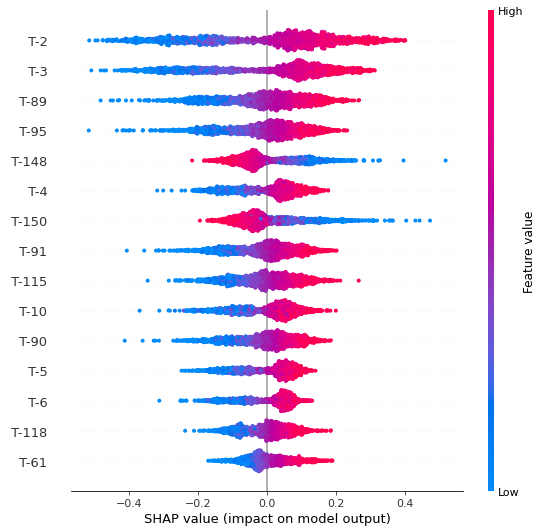

In [11]:
for dataset, params in parameters.items():
    experiment = train_and_explain(dataset, params)

In [12]:
experiment.metrics

,mae,mse,rmse,r2,mape,mae_valid,mse_valid,rmse_valid,r2_valid,mape_valid,...,model_params_units,model_params_batch_size,model_params_lr,model_params_dropout,model_params_type,code,selected_features,duration,history,val_loss
0,697.997764,9.647253e+05,982.204288,0.879548,0.025854,798.608435,1.368661e+06,1169.897770,0.857801,0.032329,...,12,85,0.00694,0.007911,tensorflow,af87ac9a045c07376dda06ff45d9a137,"{'input_tsl': ['target t-188', 'target t-187',...",16.943753,"[0.5936894416809082, 0.15845292806625366, 0.15...",0.061776
0,871.643008,1.407032e+06,1186.183625,0.836627,0.033905,773.616574,1.141313e+06,1068.322542,0.853466,0.028210,...,12,85,0.00694,0.007911,tensorflow,af87ac9a045c07376dda06ff45d9a137,"{'input_tsl': ['target t-191', 'target t-184',...",21.850704,"[0.40135282278060913, 0.3503608703613281, 0.23...",0.052913
0,1220.164666,2.496126e+06,1579.913218,0.751798,0.048393,937.590271,1.568122e+06,1252.246966,0.815692,0.036717,...,12,85,0.00694,0.007911,tensorflow,af87ac9a045c07376dda06ff45d9a137,"{'input_tsl': ['target t-192', 'target t-153',...",24.346219,"[0.5163686871528625, 0.5269386172294617, 0.403...",0.074044


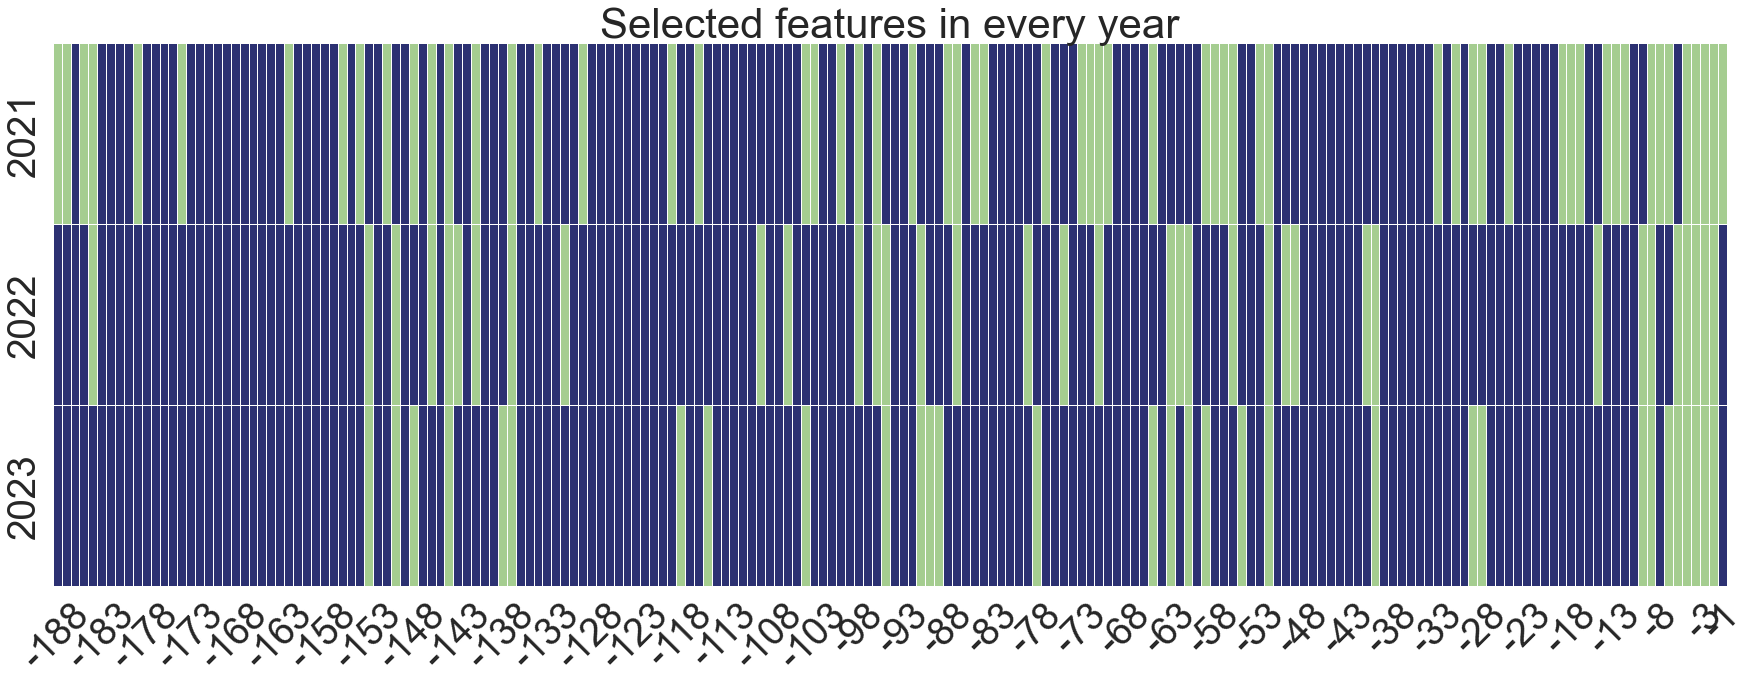

In [18]:
import seaborn as sns
sns.set(font_scale=3.5)
import numpy as np
from matplotlib.colors import ListedColormap


df_mask = pd.DataFrame()

total_metrics = experiment.metrics

total_metrics['model_name'] = total_metrics['model_name'].replace({'decisiontree': 'DT', 'lstm': "LSTM"})
total_metrics['selection_name'] = total_metrics['selection_name'].replace({'NoSelection': 'NS', 'TimeSelectionLayer': 'TSL'})

total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM'), 'model_name'] = 'TLSTM'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense'), 'model_name'] = 'TFF'
total_metrics.loc[total_metrics.selection_name=='TimeSelectionLayerConstant', 'model_name'] = 'TSL*'
#total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.selection_params_residual), 'model_name'] = 'TSLRes'
total_metrics['model_name'] = total_metrics['model_name'].replace({'dense': 'FF', 'lasso': 'L1'})

best_results = total_metrics

results_tsl_dataset = best_results[best_results.model_name=='TFF'].sort_values('dataset_params_test_year')    
selection_masks = []
seq_lens = []

for level, mask in results_tsl_dataset.selected_features.apply(eval).iloc[0].items():
    seq_lens.extend([int(name.split('t-')[1]) for name in mask])
maximum_seq_len = max(seq_lens)

for year in best_results['dataset_params_test_year'].unique():
    feat = "target"
    results_tsl_dataset_2023 = results_tsl_dataset.loc[best_results['dataset_params_test_year']==year]

    features = np.array([f'target t-{t}'for t in range (maximum_seq_len, 0, -1)])
    selected_features = results_tsl_dataset_2023.selected_features.apply(eval).map(lambda x: x['input_tsl']).apply(np.array).values[0]
    feats = features[np.core.defchararray.find(features, f"{feat} t")!=-1]
    if len(feats)==0:
        continue
    sfeats = selected_features[np.core.defchararray.find(selected_features, feat)!=-1]

    mask = np.isin(feats, sfeats).astype(np.uint)
    selection_masks.append(mask)

selection_masks = np.stack(selection_masks)

fig, ax = plt.subplots(figsize=(30,10))
ax.set_title(f'Selected features in every year')
feats = [f.replace('target t', '') if i%5 == 0 or i==len(feats)-1 else '' for i, f in enumerate(feats)]
g = sns.heatmap(selection_masks, yticklabels=best_results['dataset_params_test_year'].unique(), cmap=sns.cm.crest_r, xticklabels=feats, cbar=False, linewidth=.5, ax=ax)
plt.xticks(rotation=45)
fig = g.get_figure()

fig.savefig(f"figures/SelectionMasks/Demand/DemandMask.png", bbox_inches='tight')     


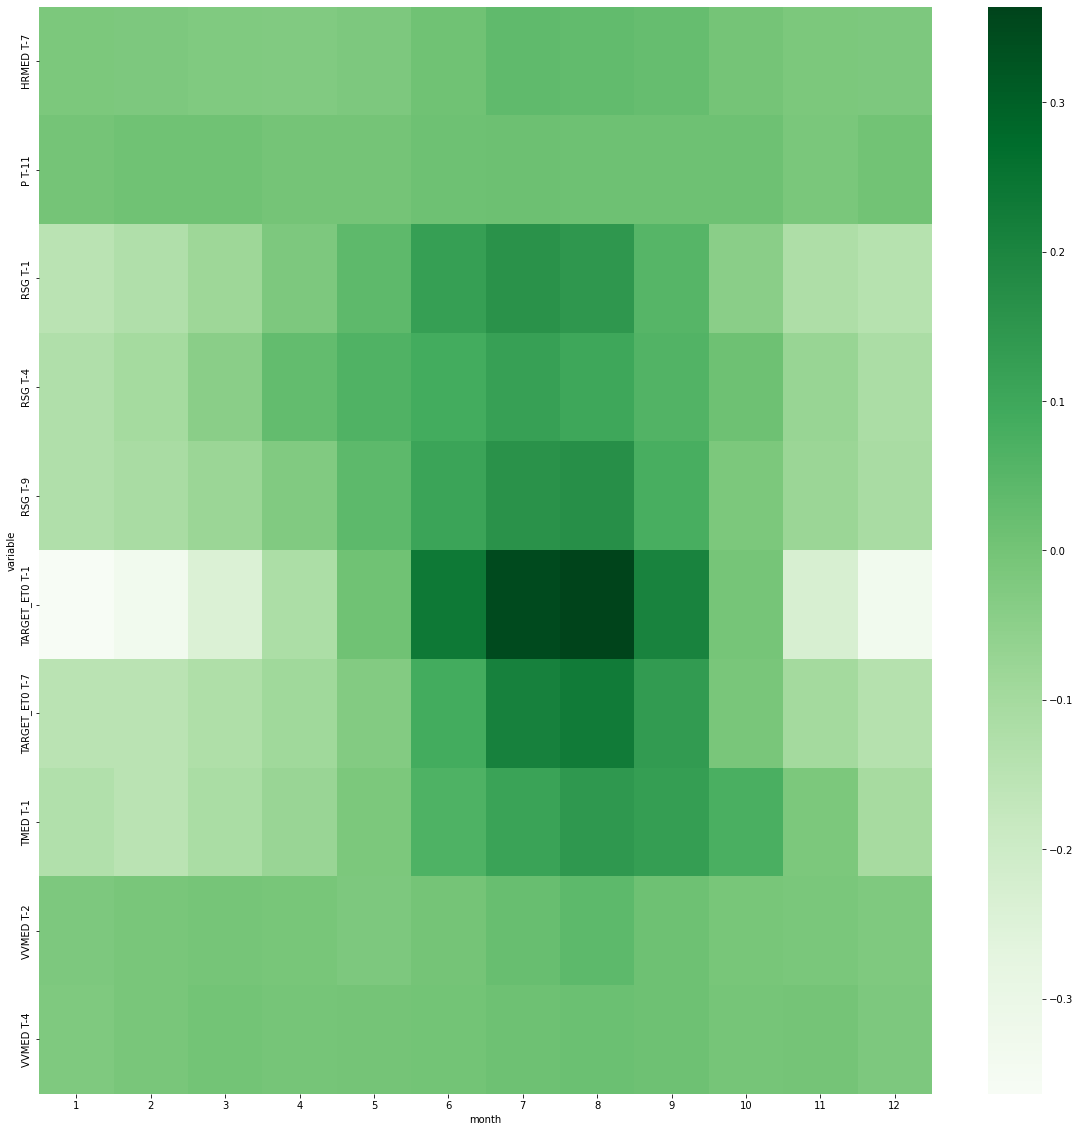

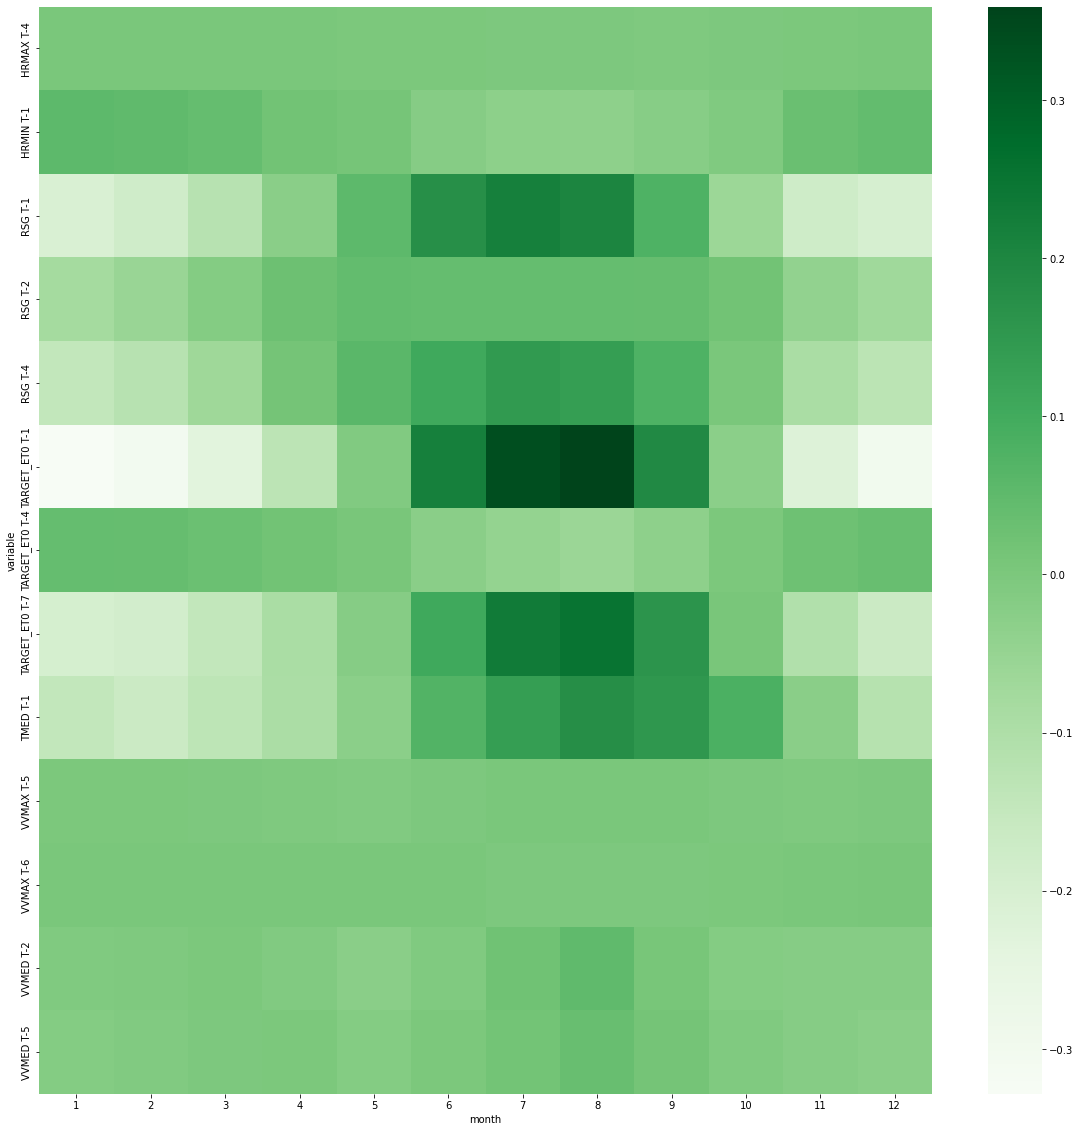

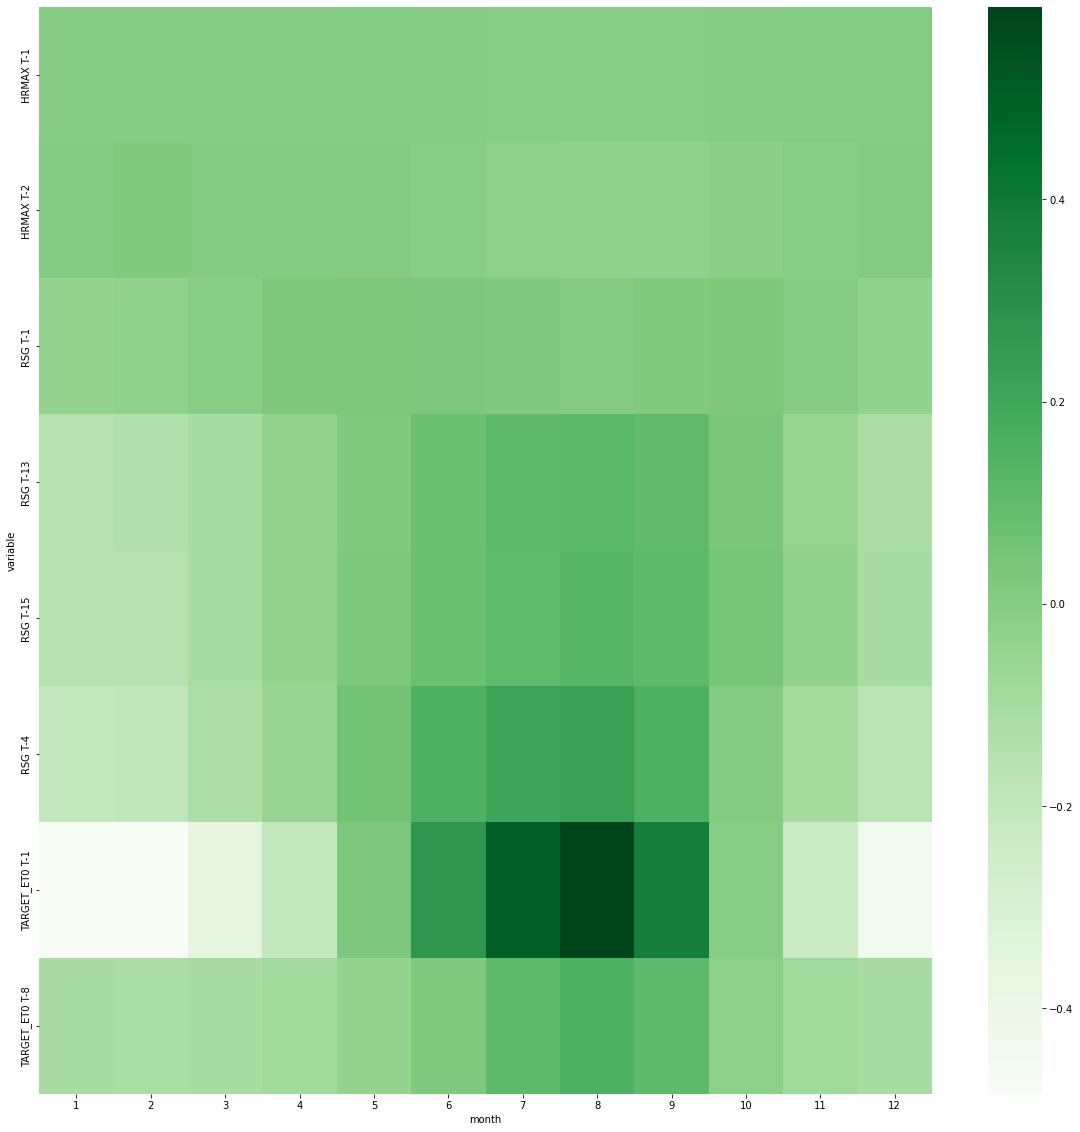

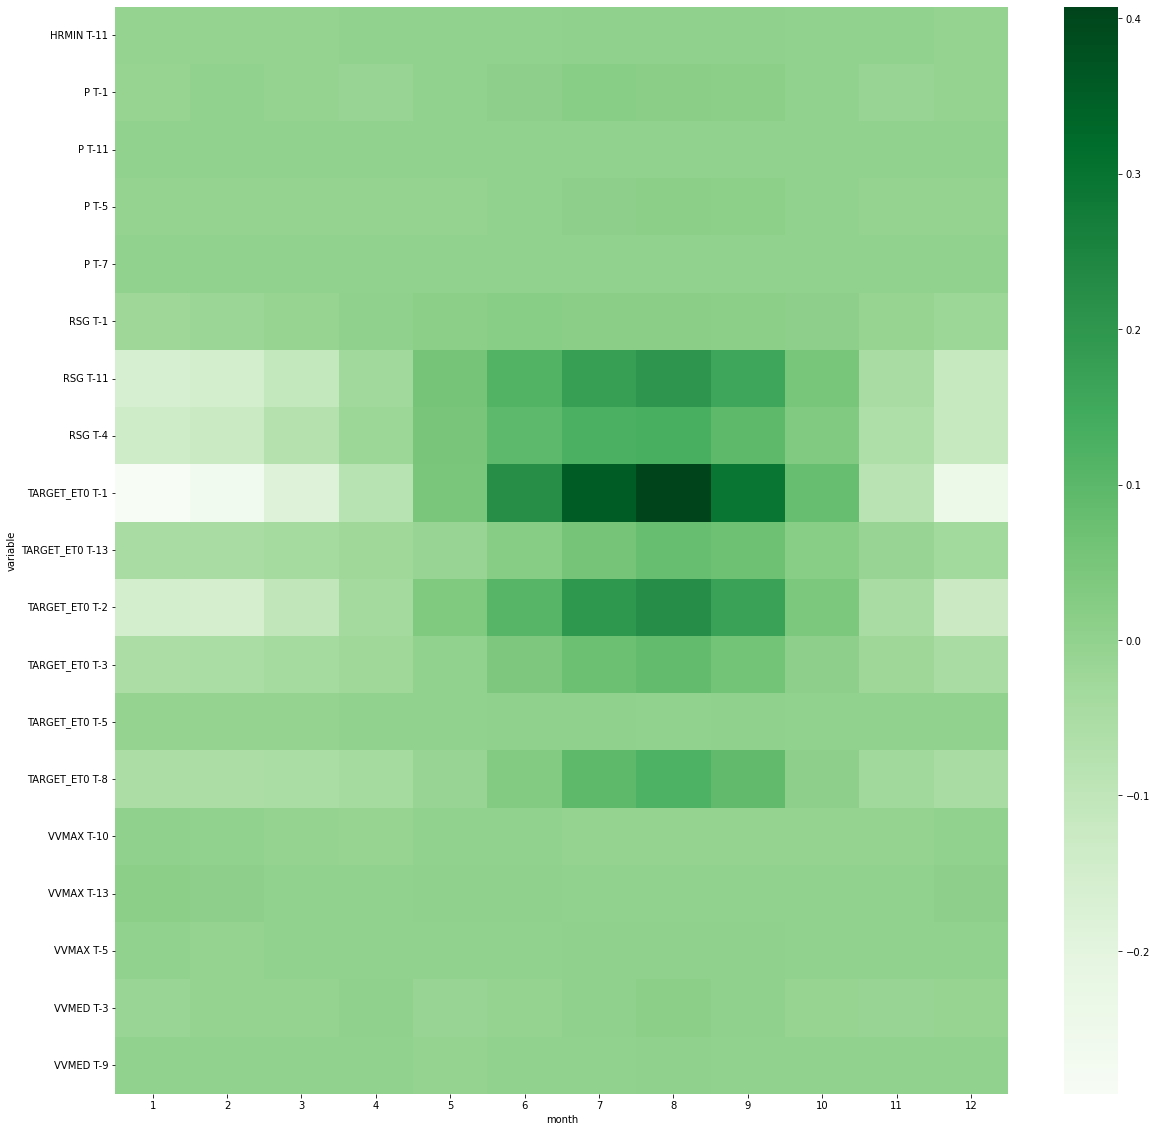

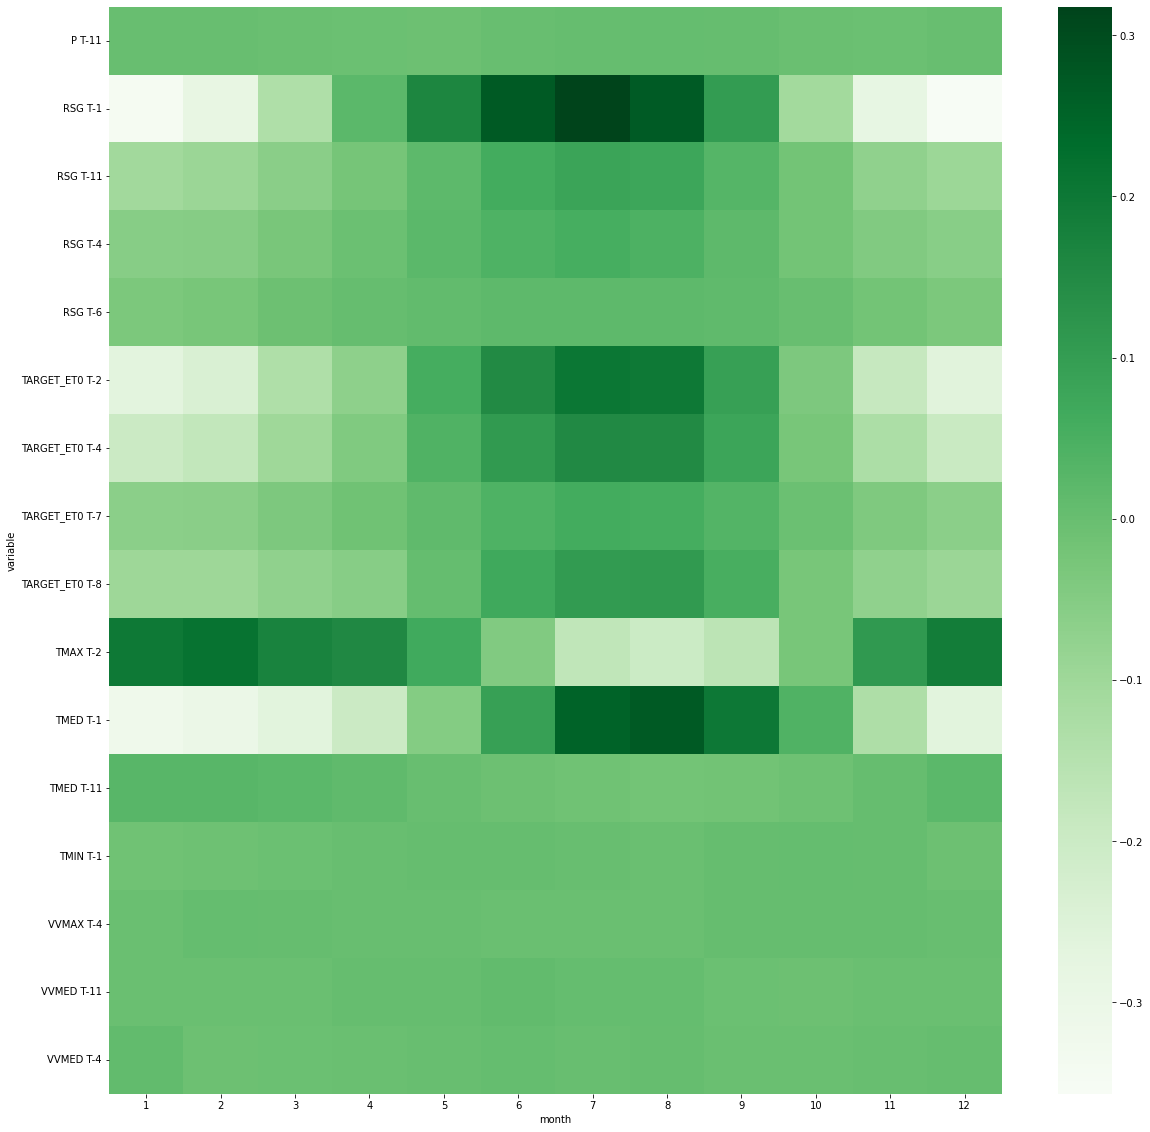

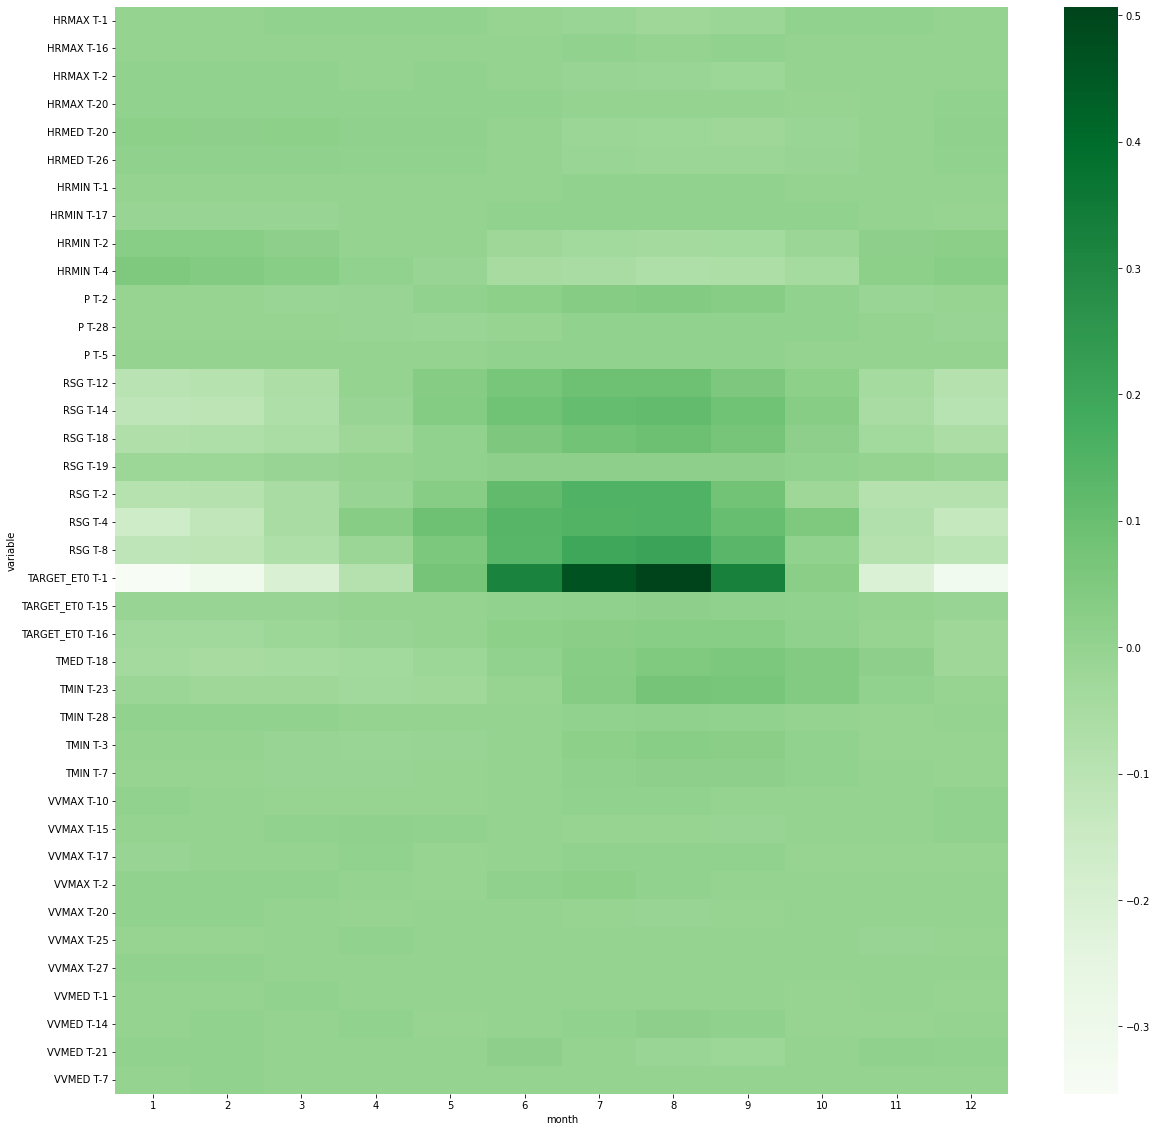

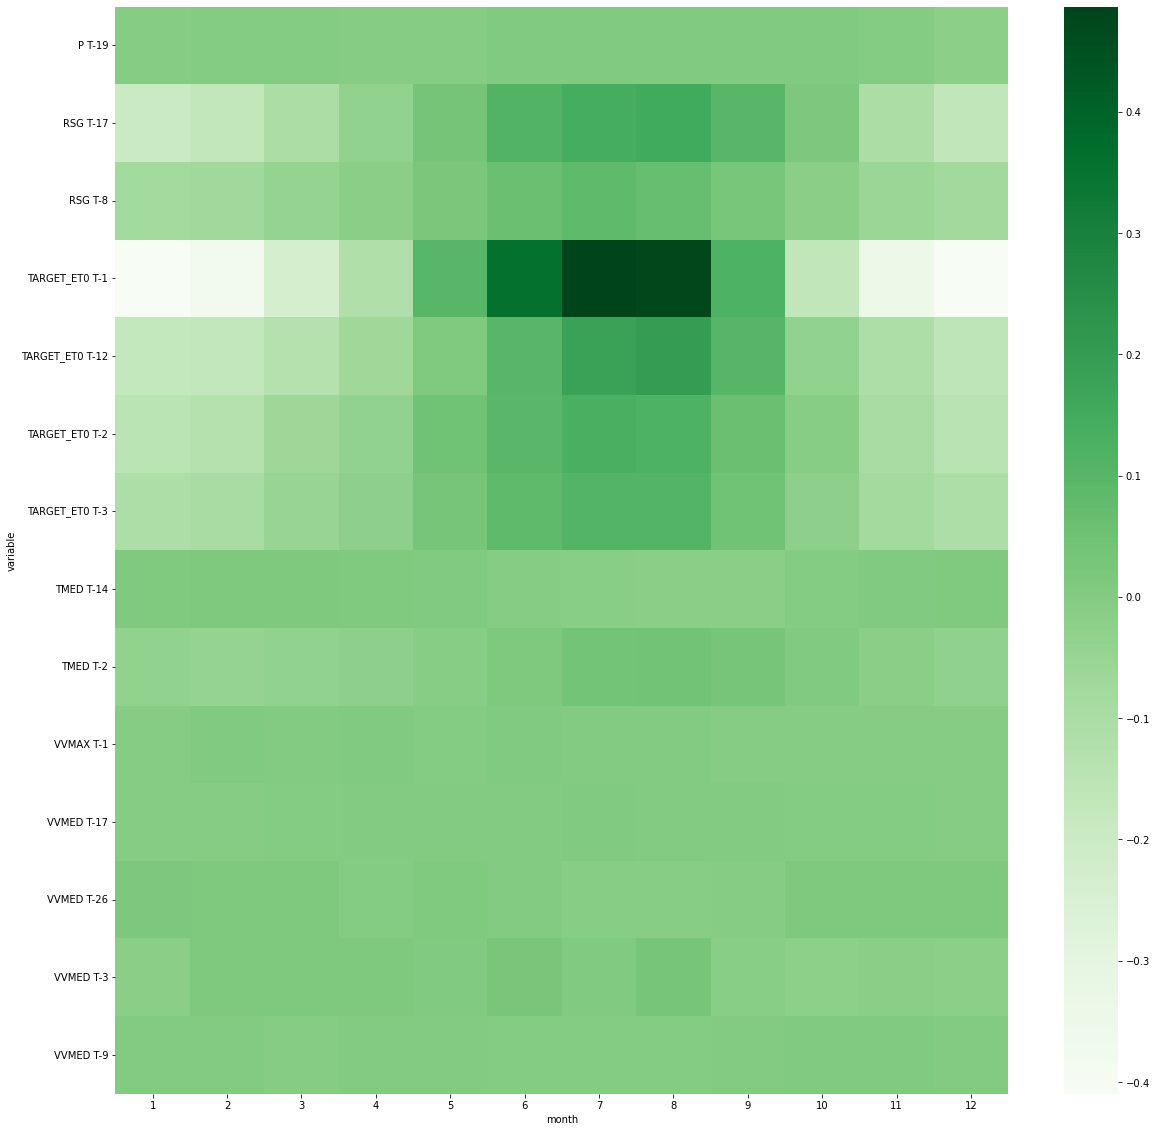

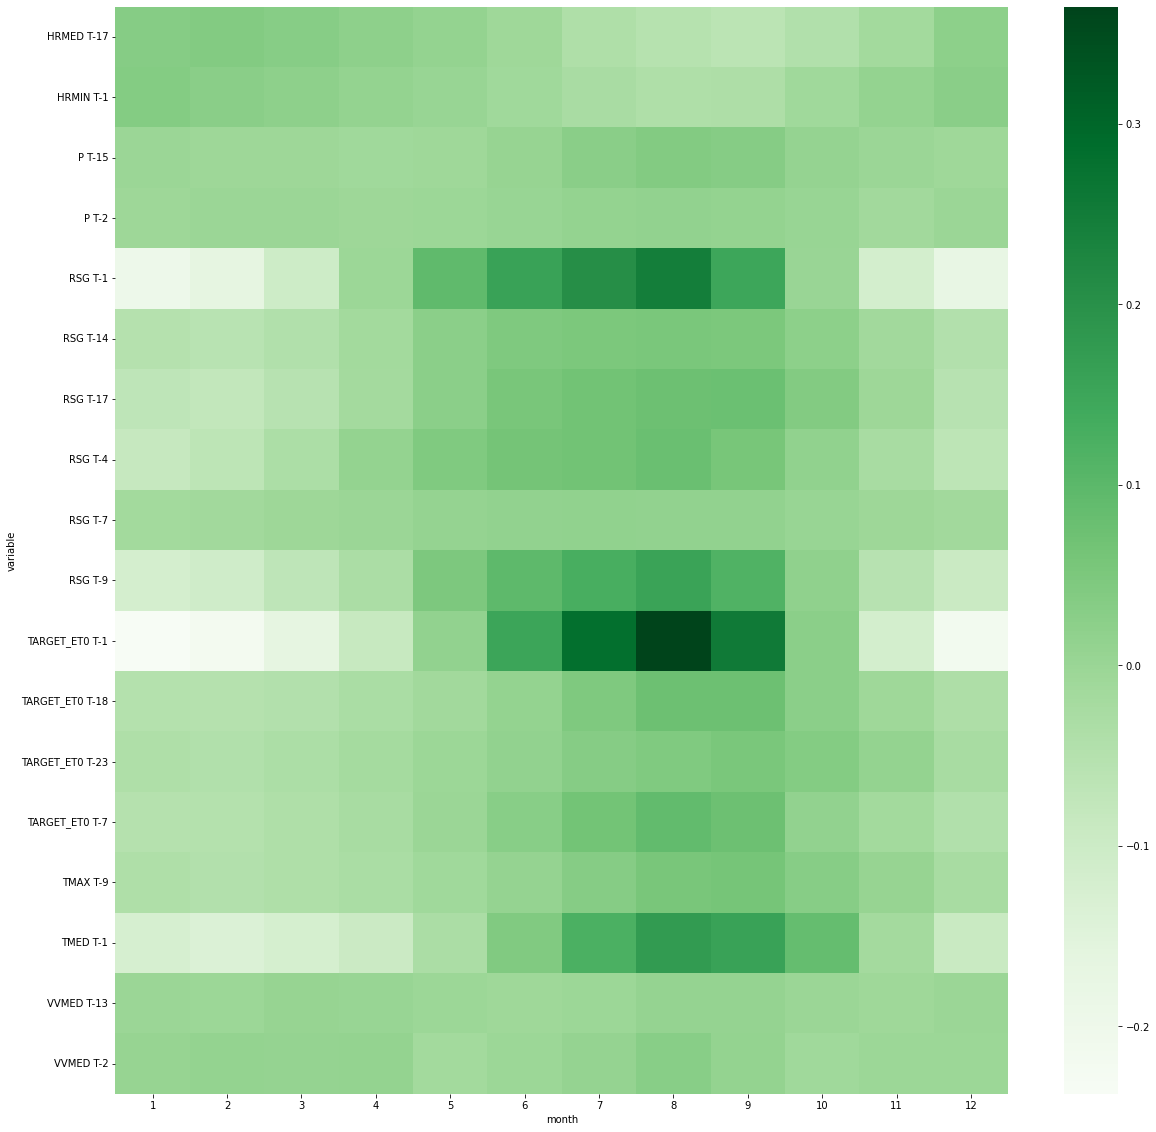

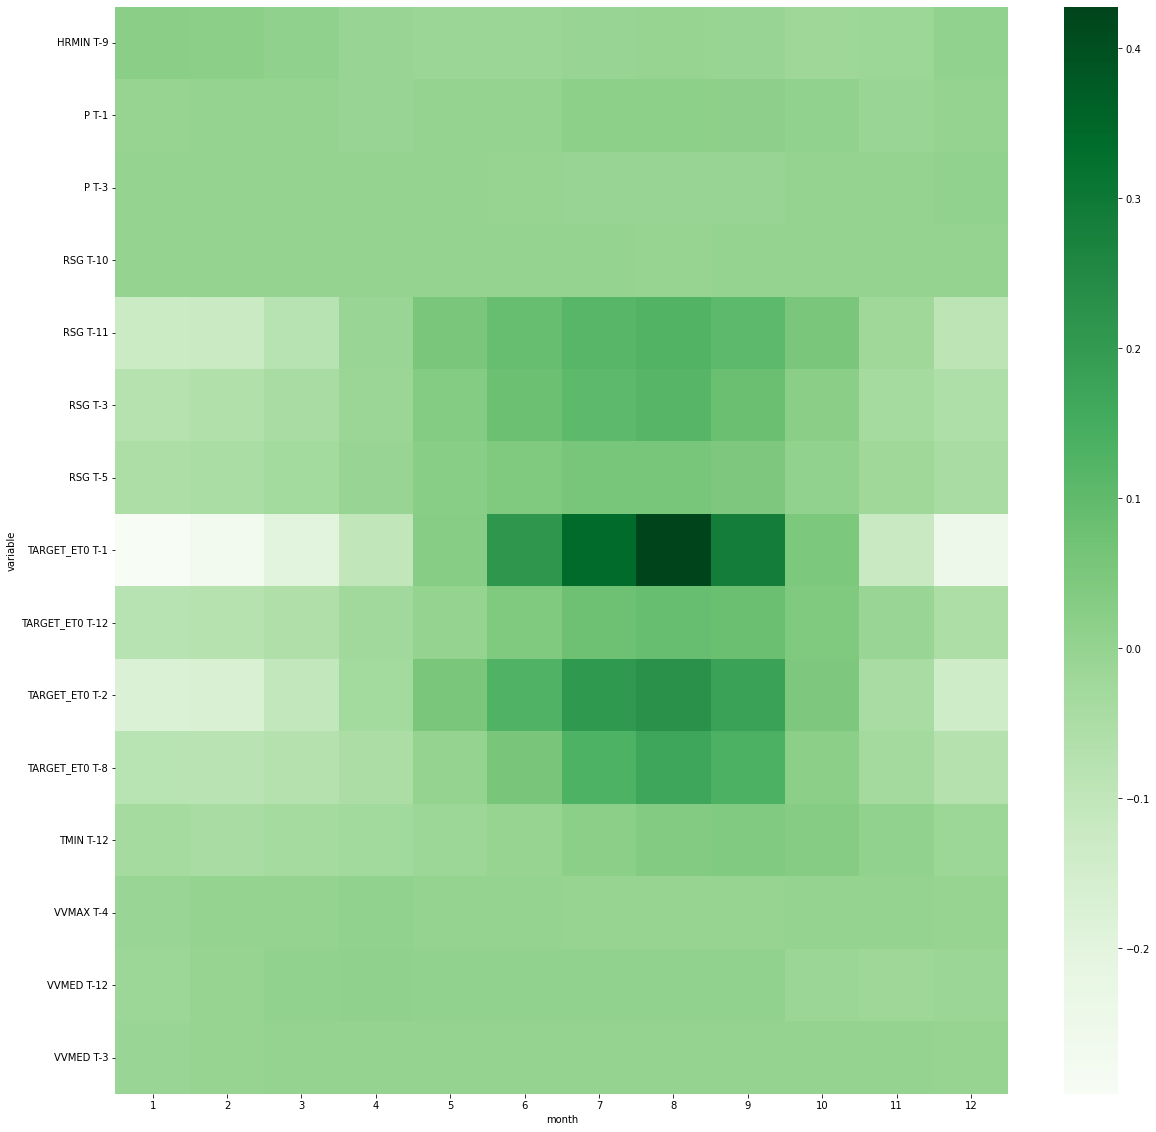

In [39]:
from glob import glob
import seaborn as sns
import os 

sns.set(style="whitegrid", font_scale=1.6)

for file in glob("results/SAGRA/importances*.csv"):
    results = pd.read_csv(file)

    results_reshaped = results.melt(id_vars=["date"], value_vars=[c.replace("TARGET_", "") for c in results.columns if "T-" in c])
    results_reshaped["month"] = pd.to_datetime(results_reshaped["date"]).dt.month

    results_reshaped = results_reshaped[results_reshaped.value.abs()>0]


    plt.figure(figsize=(20,20))
    sns.heatmap(data=results_reshaped.groupby(["month", "variable"]).mean().reset_index().sort_values("variable").pivot(index="variable", columns="month", values="value").fillna(0), cmap="Greens")

    plt.savefig(f"figures/importancemaps/{os.path.basename(file).split('.')[0]}")


In [10]:
results.pivot(id_vars=["date"], value_vars=[c for c in results.columns if "T-" in c])

,date,variable,value
0,2012-08-21,TMED T-11,0.000000
1,2012-08-24,TMED T-11,0.000000
2,2012-08-27,TMED T-11,0.000000
3,2012-08-30,TMED T-11,0.000000
4,2012-09-02,TMED T-11,0.000000
...,...,...,...
124141,2021-01-09,TARGET_ET0 T-1,-0.357380
124142,2021-01-12,TARGET_ET0 T-1,-0.387165
124143,2021-01-15,TARGET_ET0 T-1,-0.326758
124144,2021-01-18,TARGET_ET0 T-1,-0.374696
